# Test parquet partition and writing behaviour

In [1]:
import pyarrow as pa
import pyarrow.parquet
import dask.dataframe as dd
import numpy as np
import rstr
import duckdb
import pyarrow.parquet as pq

In [2]:
#id,author,title,year,x,y

In [3]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.52 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42041,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.52 GiB
Comm: tcp://127.0.0.1:35301,Total threads: 4
Dashboard: http://127.0.0.1:42951/status,Memory: 15.63 GiB
Nanny: tcp://127.0.0.1:35057,


In [4]:
import os
filename='embed_1m'
is_dataset=os.path.exists(filename)

In [ ]:
import dask.bag as db
import random
import time

from faker import Faker
n=int(1e6)
f = Faker()

def getf():
    f.seed_instance(time.time())
    return f
    
# if not is_dataset:
a= db.from_sequence(list(np.arange(n)), npartitions=32)

col_id = db.map(lambda x: x, a).compute()
col_author = db.map(lambda x: getf().name(), a).compute()
col_title = db.map(lambda x: getf().sentence(), a).compute()
col_date = db.map(lambda x: getf().date_between(start_date='-10y',end_date='-0d'), a).compute()

In [6]:
import dask
col_x = dask.array.random.normal(0, 1, n).compute()
col_y = dask.array.random.normal(0, 1, n).compute()

In [7]:
d={
    'id': col_id,
    'author': col_author,
    'title': col_title,
    'date': col_date,
    'x': col_x,
    'y': col_y
}
table=pa.table(d)


In [8]:
# pq.write_table(table, filename+'.parquet')

In [9]:
df=table.to_pandas()
df.info
df

,id,author,title,date,x,y
0,0,Marie Jacobs,Nor attention write process happen officer gla...,2023-03-14,1.614939,-0.178866
1,1,Thomas Richardson,Tv activity dream performance.,2015-02-09,0.360116,0.929351
2,2,Brittany Delgado,Direction tonight behavior after human magazin...,2017-11-12,1.054497,-0.000023
3,3,Shawn Perez,Some moment wish fall social bank today success.,2018-04-04,-0.648155,1.509551
4,4,Wendy Myers,Prove market say stop southern PM.,2015-12-09,0.355594,-0.010307
...,...,...,...,...,...,...
999995,999995,Lisa Pena,Would issue lawyer night.,2018-04-06,1.288461,-1.995682
999996,999996,Mark Thompson,But girl down include money art well.,2018-08-19,0.797676,-0.517319
999997,999997,Kenneth Rose,Media war agent prepare morning.,2021-08-01,0.016528,-1.576072
999998,999998,Stephanie Lewis,The ok trip.,2020-06-25,0.817726,-0.572813


In [10]:
schema=table.schema
with pa.OSFile(filename+'.arrow', 'wb') as sink:
    with pa.ipc.new_file(sink, schema=schema) as writer:
        batch = pa.record_batch(df, schema=schema)
        writer.write(batch)
        
with pa.memory_map(filename+'.arrow', 'rb') as source:
    table2 = pa.ipc.open_file(source).read_all()
    
df2=table2.to_pandas()
df2.info()
df2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1000000 non-null  int64  
 1   author  1000000 non-null  object 
 2   title   1000000 non-null  object 
 3   date    1000000 non-null  object 
 4   x       1000000 non-null  float64
 5   y       1000000 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 45.8+ MB


,id,author,title,date,x,y
0,0,Marie Jacobs,Nor attention write process happen officer gla...,2023-03-14,1.614939,-0.178866
1,1,Thomas Richardson,Tv activity dream performance.,2015-02-09,0.360116,0.929351
2,2,Brittany Delgado,Direction tonight behavior after human magazin...,2017-11-12,1.054497,-0.000023
3,3,Shawn Perez,Some moment wish fall social bank today success.,2018-04-04,-0.648155,1.509551
4,4,Wendy Myers,Prove market say stop southern PM.,2015-12-09,0.355594,-0.010307
...,...,...,...,...,...,...
999995,999995,Lisa Pena,Would issue lawyer night.,2018-04-06,1.288461,-1.995682
999996,999996,Mark Thompson,But girl down include money art well.,2018-08-19,0.797676,-0.517319
999997,999997,Kenneth Rose,Media war agent prepare morning.,2021-08-01,0.016528,-1.576072
999998,999998,Stephanie Lewis,The ok trip.,2020-06-25,0.817726,-0.572813


2023-09-15 22:43:14,604 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


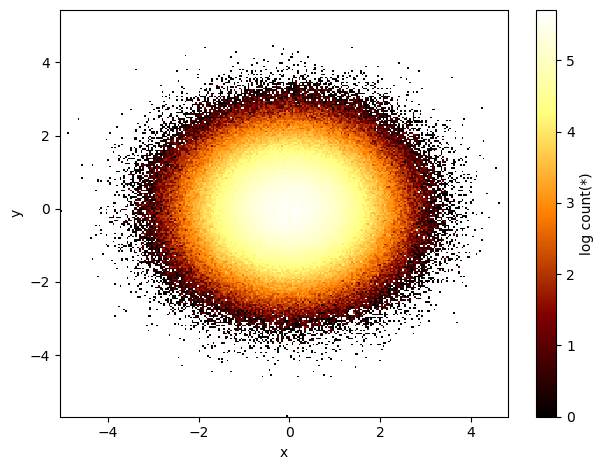

In [11]:
import vaex
df3 = vaex.open(filename+'.arrow')
df3.viz.heatmap(df3.x,df3.y,f='log')

In [12]:
table10=pa.concat_tables([table]*10)
df10=table10.to_pandas()
schema=table.schema
with pa.OSFile('embed_10m.arrow', 'wb') as sink:
    with pa.ipc.new_file(sink, schema=schema) as writer:
        batch = pa.record_batch(df10, schema=schema)
        writer.write(batch)

In [13]:
schema

id: int64
author: string
title: string
date: date32[day]
x: double
y: double

In [14]:
df10.info()
df10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   author  object 
 2   title   object 
 3   date    object 
 4   x       float64
 5   y       float64
dtypes: float64(2), int64(1), object(3)
memory usage: 457.8+ MB


,id,author,title,date,x,y
0,0,Marie Jacobs,Nor attention write process happen officer gla...,2023-03-14,1.614939,-0.178866
1,1,Thomas Richardson,Tv activity dream performance.,2015-02-09,0.360116,0.929351
2,2,Brittany Delgado,Direction tonight behavior after human magazin...,2017-11-12,1.054497,-0.000023
3,3,Shawn Perez,Some moment wish fall social bank today success.,2018-04-04,-0.648155,1.509551
4,4,Wendy Myers,Prove market say stop southern PM.,2015-12-09,0.355594,-0.010307
...,...,...,...,...,...,...
9999995,999995,Lisa Pena,Would issue lawyer night.,2018-04-06,1.288461,-1.995682
9999996,999996,Mark Thompson,But girl down include money art well.,2018-08-19,0.797676,-0.517319
9999997,999997,Kenneth Rose,Media war agent prepare morning.,2021-08-01,0.016528,-1.576072
9999998,999998,Stephanie Lewis,The ok trip.,2020-06-25,0.817726,-0.572813


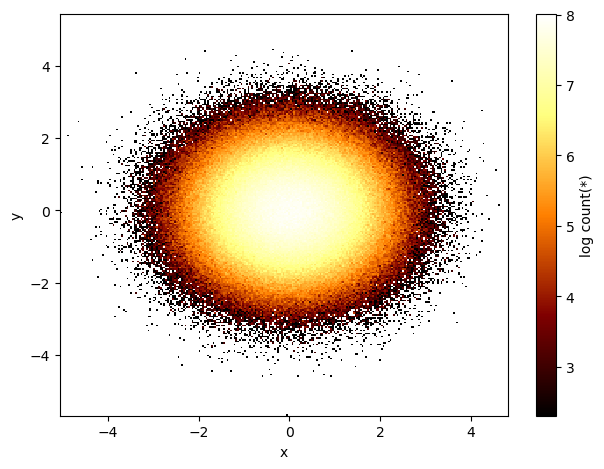

In [15]:
df10 = vaex.open('embed_10m.arrow')
df10.viz.heatmap(df10.x,df10.y,f='log')

In [16]:
df10.info()

## create a data frame
```python
import numpy as np
import pyarrow as pa

# Your data
d = {
    'col_a': list(np.arange(10)),
    'col_b': list(np.random.randn(10))
}

# Create a PyArrow table
table = pa.table(d)
df=table.to_pandas()
df
```

## test writing and reading
```python
schema=table.schema
with pa.OSFile(filename, 'wb') as sink:
    with pa.ipc.new_file(sink, schema=schema) as writer:
        batch = pa.record_batch(df, schema=schema)
        writer.write(batch)

with pa.memory_map(filename, 'rb') as source:
    table2 = pa.ipc.open_file(source).read_all()

df2=table2.to_pandas()
df2.info()
df2
```